In [11]:
import os
# !pip install torch
# !pip install torchvision
# !pip install matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/30/5b/a6214caaa5adf07b52aecba98fdace32cc51e63a1fcc1f98d60ec128a6c0/matplotlib-3.8.0-cp310-cp310-macosx_10_12_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/fb/7f/c44a51a83a093bf5c84e07dd1e3cfe9f68c47b6499bd05a9de0c6dbdc2bc/contourpy-1.1.1-cp310-cp310-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/12/20/dd3ee8dd2bc4e6bfbcd3ad4d1d79e9dba0dcc287989380ae8b520b19b4a4/fonttools-4.43.1-cp310-cp310-macosx_10_9_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 1.9 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency i

In [21]:
def get_loaders_MNIST(batch_size=100):
    transforms = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_data = tv.datasets.MNIST(root="./data/", train=True, download=True, transform=transforms)
    test_data = tv.datasets.MNIST(root="./data/", train=False, download=True, transform=transforms)
    
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [26]:
def Plot_Graph(feature, targets, epoch, save_path):
    color = ["red", "black", "yellow", "green", "pink", "gray", "lightgreen", "orange", "blue", "teal"]
    cls = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    
    plt.ion()
    plt.clf()
    for j in cls:
        mask = targets == j
        feature_ = feature[mask].numpy()
        x = feature_[:, 1]
        y = feature_[:, 0]
        plt.plot(x, y, ".", color=color[j])
    
    plt.legend(cls, loc="upper right")
    plt.title("epoch={}".format(str(epoch+1)))
    plt.savefig('{}/{}.jpg'.format(save_path, epoch+1))
    plt.show()

In [27]:
def Model_Accuracy(net, arcnet, test_loader):
    acc = 0
    for i, (x, y) in enumerate(test_loader):
        latent_out = net(x)
        arc_out = torch.log(arcnet(latent_out))
        value = torch.argmax(arc_out, dim=1)
        acc += torch.sum((value == y).float())
    print('test accuracy = ', acc.item() / len(test_loader.dataset))

In [28]:
class Network(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 64, 3, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 16, 3, 2, 1),
            nn.ReLU()
        )
        self.linear_layer = nn.Linear(16*4*4, latent_dim)
        
    def forward(self, xs):
        cnn_out = self.cnn_layers(xs)
        flatten = cnn_out.reshape(-1, 16*4*4)
        latent_out = self.linear_layer(flatten)
        return latent_out



In [29]:
class ArcNet(nn.Module):
    def __init__(self, num_classes, latent_dim, s=20, m=0.1):
        super().__init__()
        self.s = s
        self.m = torch.tensor(m)
        self.w = nn.Parameter(torch.rand(latent_dim, num_classes))
    
    def forward(self, embedding):
        embedding = F.normalize(embedding, dim=1)
        w = F.normalize(self.w, dim=0)
        cos_theta = torch.matmul(embedding, w) / self.s
        sin_theta = torch.sqrt(1.0 - torch.pow(cos_theta, 2))
        cos_theta_m = cos_theta * torch.cos(self.m) - sin_theta * torch.sin(self.m)
        cos_theta_scaled = torch.exp(cos_theta * self.s)
        sum_cos_theta = torch.sum(torch.exp(cos_theta * self.s), dim=1, keepdim=True) - cos_theta_scaled
        top = torch.exp(cos_theta_m * self.s)
        arcout = top / (top + sum_cos_theta)
        return arcout

In [30]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.delta = delta
        self.stop = False

    def __call__(self, test_accuracy):
        score = test_accuracy

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.stop = True
        else:
            self.best_score = score
            self.counter = 0


test accuracy =  0.9593
Epoch [1/50], Training Loss: 3.4062, Training Accuracy: 81.89%
test accuracy =  0.9677
Epoch [2/50], Training Loss: 3.2741, Training Accuracy: 96.79%
test accuracy =  0.9701
Epoch [3/50], Training Loss: 3.2651, Training Accuracy: 97.63%
test accuracy =  0.9797
Epoch [4/50], Training Loss: 3.2620, Training Accuracy: 97.81%
test accuracy =  0.9745
Epoch [5/50], Training Loss: 3.2592, Training Accuracy: 98.22%
test accuracy =  0.9833
Epoch [6/50], Training Loss: 3.2562, Training Accuracy: 98.45%
test accuracy =  0.9803
Epoch [7/50], Training Loss: 3.2554, Training Accuracy: 98.56%
test accuracy =  0.9854
Epoch [8/50], Training Loss: 3.2534, Training Accuracy: 98.72%
test accuracy =  0.9828
Epoch [9/50], Training Loss: 3.2500, Training Accuracy: 99.00%
test accuracy =  0.9849
Epoch [10/50], Training Loss: 3.2506, Training Accuracy: 99.03%
test accuracy =  0.9832
Epoch [11/50], Training Loss: 3.2518, Training Accuracy: 98.89%
test accuracy =  0.9863
Epoch [12/50], Tr

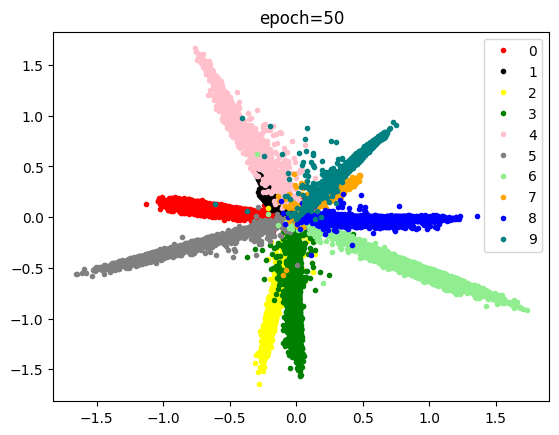

Model saved successfully!


In [31]:
def main():
    latent_dim = 3
    num_classes = 10
    net = Network(latent_dim)
    arcnet = ArcNet(num_classes, latent_dim)
    arcloss = nn.NLLLoss(reduction="mean")
    optimizerarc = torch.optim.SGD([{'params': net.parameters()}, {'params': arcnet.parameters()}], lr=0.01, momentum=0.9, weight_decay=0.0005)
    save_pic_path = "./Images"
    train_loss = []
    test_accuracy = []
    num_epochs = 50
    train_loader, test_loader = get_loaders_MNIST()
    
    os.makedirs(save_pic_path, exist_ok=True)
    
    early_stopping = EarlyStopping(patience=5, delta=0.01)  # Stop if accuracy hasn't improved by 1% in the last 10 epochs
    
    for epoch in range(num_epochs):
        net.train()
        total_loss = 0
        total_correct = 0
        total_samples = 0
        embeddings = []
        targets = []
        
        for i, (x, y) in enumerate(train_loader):
            latent_out = net(x)
            arc_out = torch.log(arcnet(latent_out))
            loss = arcloss(arc_out, y)
            optimizerarc.zero_grad()
            loss.backward()
            optimizerarc.step()
            
            total_loss += loss.item()
            predictions = torch.argmax(arc_out, dim=1)
            total_correct += torch.sum(predictions == y).item()
            total_samples += y.size(0)
            
            embeddings.append(latent_out)
            targets.append(y)

        train_accuracy = total_correct / total_samples
        train_loss.append(total_loss / len(train_loader))
        test_accuracy_val = Model_Accuracy(net, arcnet, test_loader)
        early_stopping(test_accuracy_val)

        if early_stopping.stop:
            print("Early stopping triggered!")
            break
        

        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, total_loss / len(train_loader), train_accuracy * 100))

        # Visualizing the embeddings
        all_embeddings = torch.cat(embeddings, 0)
        all_targets = torch.cat(targets, 0)
    Plot_Graph(all_embeddings.data.cpu(), all_targets.data.cpu(), epoch, save_pic_path)

    # Saving the trained model
    PATH = "model.pth"
    torch.save(net.state_dict(), PATH)
    print("Model saved successfully!")


# Run the main function
main()
